In [52]:
import json
import numpy as np
from pathlib import Path
from collections import Counter
import tqdm
import networkx as nx
from pprint import pprint

from data_reader import JsonDocReader, Document
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
from joblib import Parallel, delayed

In [7]:
def filter_common_words(documents: list[Document], min_freq: int, max_freq: float):
    assert 0 <= max_freq <= 1
    assert 0 <= min_freq <= 1

    words_counter = Counter()
    for doc in documents:
        words_counter.update(doc.tokens)

    filtered_docs = []
    total_tokens = sum(words_counter.values())
    for doc in tqdm.tqdm(documents):
        filtered_tokens = list(filter(
            lambda token: min_freq <= words_counter[token] / total_tokens <= max_freq,
            doc.tokens
        ))
        filtered_docs.append(Document(name=doc.name, tokens=filtered_tokens))

    return filtered_docs
        

In [8]:
data_reader = JsonDocReader(Path('data/docs.json')).read_documents()
docs = list(data_reader)
filtered_docs = filter_common_words(docs, min_freq=0, max_freq=0.65)

100%|██████████| 1236/1236 [00:02<00:00, 493.91it/s]


In [150]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor


_words_cache = {}
def jaccard_sim(first_doc, second_doc) -> float:
    first_doc_words = _words_cache.get(first_doc.name, set(first_doc.tokens))
    second_doc_words = _words_cache.get(second_doc.name, set(second_doc.tokens))

    _words_cache[first_doc.name] = first_doc_words
    _words_cache[second_doc.name] = second_doc_words

    return len(first_doc_words & second_doc_words) / len(first_doc_words | second_doc_words)

In [134]:
threshold = 0.7
graph = nx.Graph()
for first_ix, first_doc in tqdm.tqdm(enumerate(filtered_docs)):
    for second_ix, second_doc in enumerate(docs[first_ix + 1:]):
        sim = jaccard_sim(first_doc, second_doc)
        if sim < threshold:
            continue
        graph.add_edge(first_doc.name, second_doc.name, weight=sim)

164it [01:58,  1.38it/s]


KeyboardInterrupt: 

In [14]:
doc_name_to_doc = {doc.name: doc for doc in docs}

components = list(nx.connected_components(graph))
len(components)

92

In [158]:
def get_doc_component_most_common(component, n=20):
    words_count = Counter()
    for doc_name in component:
        words_count.update(doc_name_to_doc[doc_name].tokens)

    return words_count.most_common(n=n)


def wordcloud_from_component(component):
    print(len(component))
    most_common = get_doc_component_most_common(component)

    text = ' '.join([word for (word, count) in most_common])
    pprint(most_common)
    wordcloud = WordCloud().generate(text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

3
[('подпись', 291),
 ('цифровой', 185),
 ('точка', 101),
 ('процесс', 89),
 ('проверка', 88),
 ('кривой', 88),
 ('эллиптический', 87),
 ('сообщение', 80),
 ('число', 72),
 ('параметр', 70),
 ('схема', 65),
 ('стандарт', 62),
 ('настоящий', 60),
 ('следующий', 60),
 ('значение', 60),
 ('формирование', 58),
 ('функция', 58),
 ('двоичный', 43),
 ('вектор', 43),
 ('информационный', 41)]


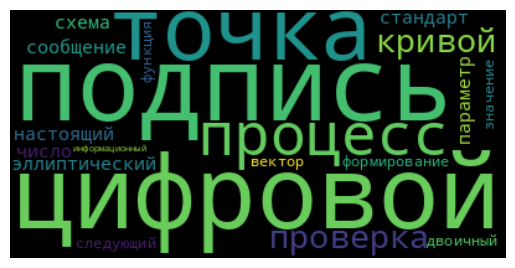

In [87]:
wordcloud_from_component(components[12])

4
[('оборудование', 3638),
 ('должный', 3307),
 ('испытание', 2654),
 ('напряжение', 2569),
 ('часть', 2240),
 ('требование', 2002),
 ('изоляция', 1917),
 ('электропитание', 1722),
 ('значение', 1648),
 ('соответствие', 1492),
 ('провод', 1406),
 ('материал', 1046),
 ('примечание', 1045),
 ('проводить', 947),
 ('защита', 925),
 ('заземление', 908),
 ('использовать', 906),
 ('защитный', 902),
 ('условие', 883),
 ('устройство', 871)]


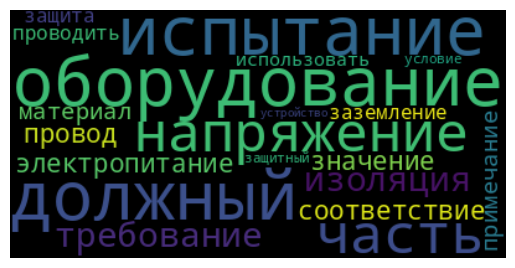

In [88]:
wordcloud_from_component(components[18])

2
[('измерение', 273),
 ('экран', 187),
 ('изображение', 178),
 ('яркость', 134),
 ('область', 127),
 ('должный', 125),
 ('время', 110),
 ('значение', 110),
 ('характеристика', 107),
 ('дисплей', 105),
 ('световой', 100),
 ('горизонтальный', 91),
 ('поток', 89),
 ('частота', 85),
 ('испытательный', 84),
 ('вертикальный', 79),
 ('разрешение', 78),
 ('свет', 75),
 ('выходной', 74),
 ('система', 73)]


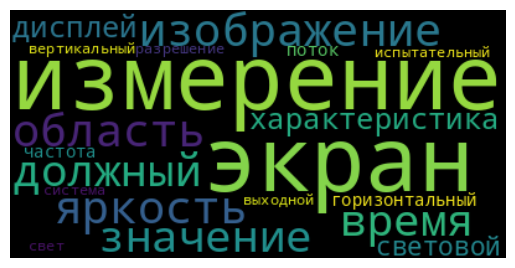

In [89]:
wordcloud_from_component(components[21])

2
[('изображение', 1046),
 ('палец', 845),
 ('должный', 733),
 ('отпечаток', 538),
 ('сканер', 488),
 ('значение', 484),
 ('биометрический', 475),
 ('частота', 374),
 ('данных', 315),
 ('качество', 302),
 ('таблица', 289),
 ('область', 278),
 ('серый', 263),
 ('уровень', 246),
 ('требование', 223),
 ('каждый', 223),
 ('испытание', 209),
 ('регистрация', 207),
 ('содержать', 199),
 ('зарегистрировать', 198)]


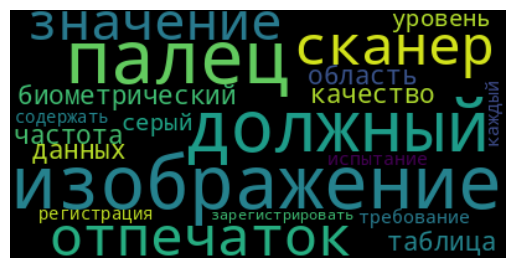

In [91]:
wordcloud_from_component(components[45])

2
[('полоса', 178),
 ('управление', 145),
 ('должный', 135),
 ('спспд', 133),
 ('водитель', 126),
 ('система', 116),
 ('испытание', 104),
 ('движение', 101),
 ('смена', 84),
 ('рулевой', 82),
 ('сигнал', 71),
 ('скорость', 65),
 ('требование', 59),
 ('указать', 59),
 ('помощь', 58),
 ('функция', 52),
 ('средство', 51),
 ('условие', 51),
 ('изготовитель', 51),
 ('испытательный', 46)]


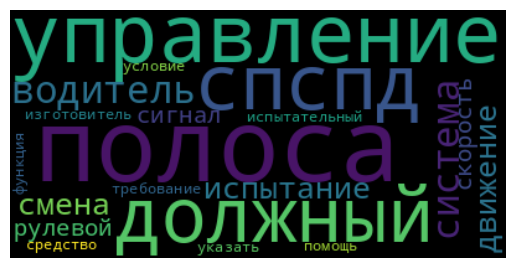

In [94]:
wordcloud_from_component(components[47])

2
[('сертификат', 420),
 ('медицинский', 343),
 ('электронный', 230),
 ('информация', 226),
 ('здравоохранение', 225),
 ('ключ', 187),
 ('пациент', 156),
 ('система', 140),
 ('сфера', 122),
 ('являться', 118),
 ('работник', 116),
 ('использовать', 115),
 ('безопасность', 112),
 ('доступ', 108),
 ('организация', 104),
 ('сторона', 100),
 ('помощь', 95),
 ('мочь', 95),
 ('также', 90),
 ('стандарт', 87)]


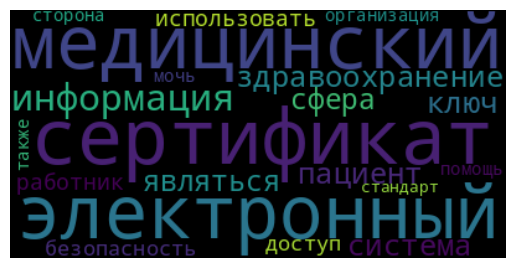

In [131]:
wordcloud_from_component(components[83])

2
[('сертификат', 478),
 ('здравоохранение', 145),
 ('должный', 124),
 ('наименование', 117),
 ('ключ', 100),
 ('медицинский', 100),
 ('субъект', 95),
 ('организация', 93),
 ('расширение', 82),
 ('идентификатор', 79),
 ('являться', 71),
 ('система', 70),
 ('identifier', 69),
 ('информация', 67),
 ('формат', 65),
 ('object', 65),
 ('цифровой', 64),
 ('использовать', 63),
 ('объект', 63),
 ('открыть', 61)]


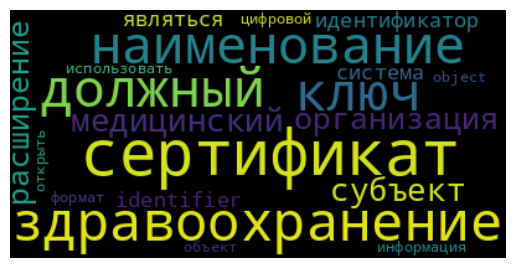

In [132]:
wordcloud_from_component(components[84])

In [152]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz

--2023-11-03 16:59:07--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.244.140.22, 18.244.140.2, 18.244.140.119, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.244.140.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1306357571 (1,2G) [binary/octet-stream]
Saving to: ‘cc.ru.300.vec.gz’

cc.ru.300.vec.gz    100%[===================>]   1,22G  15,5MB/s    in 1m 47s  

2023-11-03 17:00:56 (11,6 MB/s) - ‘cc.ru.300.vec.gz’ saved [1306357571/1306357571]



In [153]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('cc.ru.300.vec.gz', binary=False)

In [162]:
import numpy as np


avg_sim = 0
for component in components:
    most_common_words = [word for word, count in get_doc_component_most_common(component)]
    vectors = [model[word] for word in most_common_words if word in model]

    avg_component_sim = 0
    for i, vec1 in enumerate(vectors):
        for vec2 in vectors[i + 1:]:
            avg_component_sim += (vec1 @ vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    avg_sim += avg_component_sim / (20 * 19 / 2)
avg_sim /= len(components)

In [163]:
avg_sim

0.20802610966725935